## Implementation of ARSOM -  Association Rule Selection Optimization Model

We will use 'Association Rule Mining' and 'Mixed-Integer Programming'  to find the optimal rule set to correctly predict the positive class while minimizing the number of features used for prediction.

By Tushar Sharma and Chun-An Chou, 2021, July 12

Reference: Chun-An Chou, Qingtao Cao, Shao-Jen Weng, Che-Hung Tsai, Mixed-Integer Optimization Approach to Learning Association Rules for Unplanned ICU Transfer, Artificial Intelligence in Medicine, 103, 101806, 2020

In [2]:
# Python Dataframe & numeric libraries
import pandas as pd
import numpy as np

# Association rule mining library
from mlxtend.frequent_patterns import apriori, association_rules

# Gurobi optimization library
import gurobipy as gp
from gurobipy import GRB

# Evaluation & Visualization libraries
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

### Read the data into pandas dataframe

Here we read the provided dataset which will be Matrix 'A' that represents ['datapoints' X 'features'].
- Column name for feature that resprents class must be 'Class'.
- Any unnecessary can be removed by passing their name in the list.

In [21]:
df = pd.read_csv('toydata.csv')

# Rename Class variable
df.rename(columns={'Class': 'Class'},inplace=True)

# Remove columns not required (add column names below)
df.drop(columns = [], inplace=True)

df

,f1,f2,f3,f4,f5,Class
0,1,0,1,0,1,1
1,1,1,1,0,0,1
2,1,0,1,0,1,1
3,1,1,1,0,0,1
4,1,0,0,1,0,1
5,1,0,1,1,1,1
6,1,1,1,1,1,1
7,1,1,0,0,0,0
8,0,0,1,0,0,0
9,0,0,0,0,0,0


### Function definition for calculating coverage

- Coverage for a rule/feature is defined by number of positive/negative points covered by them.



In [4]:
def coverage(rule,klass):
    """ Function used to calculate coverage of a rule"""
    return(sum(df.loc[df['Class']==klass][rule].apply(lambda x: all(x), axis = 1)))

def check_rules(num,rules):
    """ Function used to create matrix C"""
    lis = []
    for i in rules.index:
        lis.append(int(all(df[rules['itemsets'][i]].loc[num])))
    return lis

def check_rules_features():
    itemsets_unraveled = arules.explode('itemsets')['itemsets']
    rules_features = pd.DataFrame(data = 0, index = df.columns[:-1], columns = arules.index)

    for i in itemsets_unraveled.iteritems():
        rules_features.loc[i[1]][i[0]] = 1
        
    return rules_features



## 1. Selecting relevant rules using Association rules

### Approach 'A': Regular Association rules

First we implement regular association rules technique that considers class as a feature(item).
Conclusively, we find out the association rules with class = 1.

- Here we mine for frequent itemsets using 'apriori algorithm'

In [22]:
frequent_itemsets = apriori(df, min_support=0.2, use_colnames = True)
frequent_itemsets

,support,itemsets
0,0.588235,(f1)
1,0.411765,(f2)
2,0.588235,(f3)
3,0.294118,(f4)
4,0.235294,(f5)
5,0.411765,(Class)
6,0.352941,"(f2, f1)"
7,0.470588,"(f1, f3)"
8,0.235294,"(f1, f4)"
9,0.235294,"(f1, f5)"


- Next, we select association rules with only 'Class' in RHS(consequent) since this will represent rules to identify positive class. 
- Coverage is calculated for both + (Tcovered) and - (Ncovered) datapoints.

In [23]:
arules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
arules = arules[arules['consequents'] == frozenset({'Class'})]
arules = arules[['antecedents','support','confidence','lift']]
arules['size'] = arules['antecedents'].apply(lambda x: len(x))
arules['Tcovered'] = arules['antecedents'].apply(lambda x: coverage(x,1))
arules['Ncovered'] = arules['antecedents'].apply(lambda x: coverage(x,0))
arules.rename(columns = {'antecedents': 'itemsets'}, inplace=True)
arules.reset_index(drop=True,inplace=True)
arules['itemsets'] = arules['itemsets'].apply(lambda x: list(x))
arules

,itemsets,support,confidence,lift,size,Tcovered,Ncovered
0,[f1],0.411765,0.70,1.700000,1,7,3
1,[f3],0.352941,0.60,1.457143,1,6,4
2,[f5],0.235294,1.00,2.428571,1,4,0
3,"[f1, f3]",0.352941,0.75,1.821429,2,6,2
4,"[f1, f5]",0.235294,1.00,2.428571,2,4,0
5,"[f3, f5]",0.235294,1.00,2.428571,2,4,0
6,"[f1, f3, f5]",0.235294,1.00,2.428571,3,4,0


- Matrix B is ['rules' X 'features'] matrix. For each rule we check if the feature is covered and mark it 1.

In [24]:
#Matrix B
rules_features = check_rules_features()
rules_features

,0,1,2,3,4,5,6
f1,1,0,0,1,1,0,1
f2,0,0,0,0,0,0,0
f3,0,1,0,1,0,1,1
f4,0,0,0,0,0,0,0
f5,0,0,1,0,1,1,1


- Matrix C is a ['datapoint' X 'rules'] matrix and we use check_rules() function to create it.

In [25]:
#Matrix C

df_rules_data = [check_rules(x,arules) for x in df.index]
df_rules = pd.DataFrame(data = df_rules_data, index = df.index, columns = arules.index)
df_rules['Class'] = df['Class']

df_rules

,0,1,2,3,4,5,6,Class
0,1,1,1,1,1,1,1,1
1,1,1,0,1,0,0,0,1
2,1,1,1,1,1,1,1,1
3,1,1,0,1,0,0,0,1
4,1,0,0,0,0,0,0,1
5,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1
7,1,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0


**NOTE:** SKIP TO STEP 2. OPTIMIZATION IF THE APPROACH 'A' WORKED ON DATASET.

### Approach 'B': Using frequent itemsets and their support as P(Class = 1 | Rule)

This approach is to be used only if approach 'A' is not feasible in case of a significantly large dataset.

- Separate true cases for class = 1

In [8]:
df_class1 = df[df.Class == 1].copy()
df_class1.drop(columns = ['Class'], inplace = True)
df_class1

,f1,f2,f3,f4,f5
0,1,0,1,0,1
1,1,1,1,0,0
2,1,0,1,0,1
3,1,1,1,0,0
4,1,0,0,1,0
5,1,0,1,1,1
6,1,1,1,1,1


 - Mining frequent itemsets using *'apriori algorithm'* and calculating coverage

In [9]:
frequent_itemsets = apriori(df_class1, min_support=0.5, use_colnames = True)

arules = frequent_itemsets

arules['size'] = arules['itemsets'].apply(lambda x: len(x))
arules['Tcovered'] = arules['itemsets'].apply(lambda x: coverage(x,1))
arules['Ncovered'] = arules['itemsets'].apply(lambda x: coverage(x,0))
arules['itemsets'] = arules['itemsets'].apply(lambda x: list(x))
arules

,support,itemsets,size,Tcovered,Ncovered
0,1.000000,[f1],1,7,3
1,0.857143,[f3],1,6,4
2,0.571429,[f5],1,4,0
3,0.857143,"[f1, f3]",2,6,2
4,0.571429,"[f1, f5]",2,4,0
5,0.571429,"[f3, f5]",2,4,0
6,0.571429,"[f1, f3, f5]",3,4,0


- Matrix B is ['rules' X 'features'] matrix. For each rule we check if the feature is covered and mark it 1.

In [10]:
#Matrix B

rules_features = check_rules_features()
rules_features

,0,1,2,3,4,5,6
f1,1,0,0,1,1,0,1
f2,0,0,0,0,0,0,0
f3,0,1,0,1,0,1,1
f4,0,0,0,0,0,0,0
f5,0,0,1,0,1,1,1


- Matrix C is a ['datapoint' X 'rules'] matrix and we use check_rules() function to create it.

In [11]:
#Matrix C

df_rules_data = [check_rules(x,arules) for x in df.index]
df_rules = pd.DataFrame(data = df_rules_data, index = df.index, columns = arules.index)
df_rules['Class'] = df['Class']

df_rules

,0,1,2,3,4,5,6,Class
0,1,1,1,1,1,1,1,1
1,1,1,0,1,0,0,0,1
2,1,1,1,1,1,1,1,1
3,1,1,0,1,0,0,0,1
4,1,0,0,0,0,0,0,1
5,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1
7,1,0,0,0,0,0,0,0
8,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0


## 2. OPTIMIZATION: Finding optimal rule set using integer programming

### Define the problem:


Our optimization problem is as follows:

**MIN:** $\alpha\  \Sigma y_j$ + $\beta \  \Sigma z_k$ + $\gamma \  \Sigma x_i^-$ - $\lambda \  \Sigma x_i^+$

**ST:**  $\Sigma$ $ c_{ik}^+ z_k \ge x_i \ \  \forall \  i \in I^+ $

$\Sigma$ $ c_{ik}^- z_k \ge M_1 x_i \ \  \forall \  i \in I^- $

$\Sigma$ $ b_{jk}^- z_k \ge M_2 y_j \ \  \forall \  j \in J $

- Check the problem parameters (change 'l' if needed) in Gurobi and run the optimization model in following cell

In [12]:
gp.disposeDefaultEnv()

J,K,I_P,I=len(rules_features.index),len(rules_features.columns),df['Class'].sum(),len(df.index)

c_P_df = df_rules.loc[df_rules['Class'] == 1, df_rules.columns !='Class'].reset_index(drop=True).transpose()

c_N_df = df_rules.loc[df_rules['Class'] == 0, df_rules.columns !='Class'].reset_index(drop=True).transpose()

bf = rules_features.reset_index(drop = True).transpose()

# SET the lambda coefficient
l = 10

In [26]:
try:
    # Create a new model
    A = gp.Model("mip1")
    
    # Create variables
    x = A.addVars(I, vtype=GRB.BINARY, name="x")
    #xneg = A.addVars(10, vtype=GRB.BINARY, name="xneg")
    y = A.addVars(J, vtype=GRB.BINARY, name="y")
    z = A.addVars(K, vtype=GRB.BINARY, name="z")
    
    # Set objective
    
    A.setObjective(gp.quicksum(y[j] for j in range(J))+
                   gp.quicksum(z[k] for k in range(K))+
                   gp.quicksum(x[i] for i in range(I_P,I))-
                   l*gp.quicksum(x[i] for i in range(I_P)),
                   GRB.MINIMIZE)
    
    # Add constraint: sigma{c_i_k+ * z_k} >= x_i
    for i in range(I_P):
        A.addConstr(gp.quicksum(c_P_df[i][k] * z[k] for k in range(K))>= x[i], name='con1')
    
    # Add constraint: sigma{c_i_k- * z_k} <= M_1 * x_i
    for i in range(I_P,I):
        i1=i-I_P
        A.addConstr(gp.quicksum(c_N_df[i1][k] * z[k] for k in range(K))<= (K+1) * x[i], name='con2')
    
    # Add constraint: sigma{b_j_k * z_k} <= M_2 * y_j
    for j in range(J):
        A.addConstr(gp.quicksum(bf[j][k] * z[k] for k in range(K))<= (K+1) * y[j], name='con3')
    
    # Optimize model
    A.optimize()
    
    for v in A.getVars():
            print('%s %g' % (v.varName, v.x))
    
    print('Obj: %g' % A.objVal)

except gp.GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 22 rows, 29 columns and 78 nonzeros
Model fingerprint: 0x5fbd0b92
Variable types: 0 continuous, 29 integer (29 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 0.0000000
Found heuristic solution: objective -61.0000000
Presolve removed 22 rows and 29 columns
Presolve time: 0.01s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.08 seconds
Thread count was 1 (of 4 available processors)

Solution count 3: -65 -61 0 
No other solutions better than -65

Optimal solution found (tolerance 1.00e-04)
Best objective -6.500000000000e+01, best bound -6.500000000000e+01, gap 0.0000%
x[0] 1
x[1] 1
x[2] 1
x[3] 1
x[4] 1
x[5] 1
x[6] 1
x[7] 1
x[8] 0
x[9] 0
x[10] 0
x[

- Now we subset arules dataframe to observe only the selected rules after optimization

In [15]:
z_rules = []
for v in A.getVars():
    if 'z' in v.varName:
        z_rules.append(bool(v.x))

#rules_final = [i for i in arules[z_rules].sort_values(by = 'support', ascending = False)['itemsets']]
rules_final = [i for i in arules[z_rules]['itemsets']]
rules_final

[['f1']]

## 3. Evaluation

Here we will use selected rules to predict the class of training dataset. Evaluation includes analyzing confusion matrix and the AUC plots.

- Calculate prediction probabilities for a datapoint using average support of all the rules that satisfy that datapoint.

In [16]:
y_predict_proba=[]

for j in df.index:
    colsup = []
    for i in arules[z_rules].index:
        if all(df.iloc[j,:][arules.iloc[i]['itemsets']]) == True:
            colsup.append(arules.iloc[i]['support'])
    try:
        y_predict_proba.append(sum(colsup)/len(colsup))
    except ZeroDivisionError:
        y_predict_proba.append(0)

y_predict_proba

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0, 0, 1.0, 1.0, 0, 0, 0]

- Convert prediction probabilities to predicted class by converting to boolean.

In [17]:
y_predicted = [bool(i) for i in y_predict_proba]
y_predict_proba = np.array(y_predict_proba)

y_predicted

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False]

- Calculate and plot confusion matrix using predicted and true labels

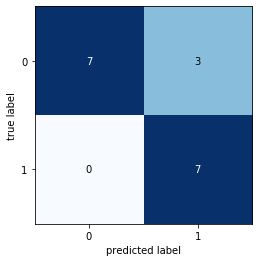

In [18]:
y_target = list(df['Class'])
cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

In [19]:
my_func = lambda x: 1-x

y_proba = np.vstack((y_predict_proba,[my_func(i) for i in y_predict_proba])).T
y_test = np.vstack((y_target,[my_func(i) for i in y_target])).T

y_proba

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

- Plot the AUC curve by calculating FPR, TPR at different thresholds using roc_curve() function.

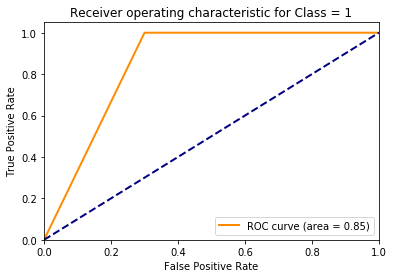

In [20]:
n_classes = len(set(df['Class']))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Class = 1')
plt.legend(loc="lower right")
plt.show()